In [472]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

Reading Data

In [449]:
dataset = pd.read_excel('input_data/SWaT_Dataset_Attack_v0.xlsx', header = 1)

C:\Users\79175\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [450]:
dataset[' Timestamp'] = pd.to_datetime(dataset[' Timestamp'])

dataset.columns = dataset.columns.str.replace(' ', '')

#Replacing dirty values
dataset.loc[dataset['Normal/Attack'] == 'A ttack', 'Normal/Attack'] = 'Attack'
dataset.loc[dataset['Normal/Attack'] == 'Attack', 'Normal/Attack'] = 1
dataset.loc[dataset['Normal/Attack'] == 'Normal', 'Normal/Attack'] = 0
dataset['Normal/Attack']  = dataset['Normal/Attack'].astype('int8')

Checking gaps and overall info

In [451]:
dataset.isna().sum().sum()

0

In [452]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449919 entries, 0 to 449918
Data columns (total 53 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Timestamp      449919 non-null  datetime64[ns]
 1   FIT101         449919 non-null  float64       
 2   LIT101         449919 non-null  float64       
 3   MV101          449919 non-null  int64         
 4   P101           449919 non-null  int64         
 5   P102           449919 non-null  int64         
 6   AIT201         449919 non-null  float64       
 7   AIT202         449919 non-null  float64       
 8   AIT203         449919 non-null  float64       
 9   FIT201         449919 non-null  float64       
 10  MV201          449919 non-null  int64         
 11  P201           449919 non-null  int64         
 12  P202           449919 non-null  int64         
 13  P203           449919 non-null  int64         
 14  P204           449919 non-null  int64         
 15  

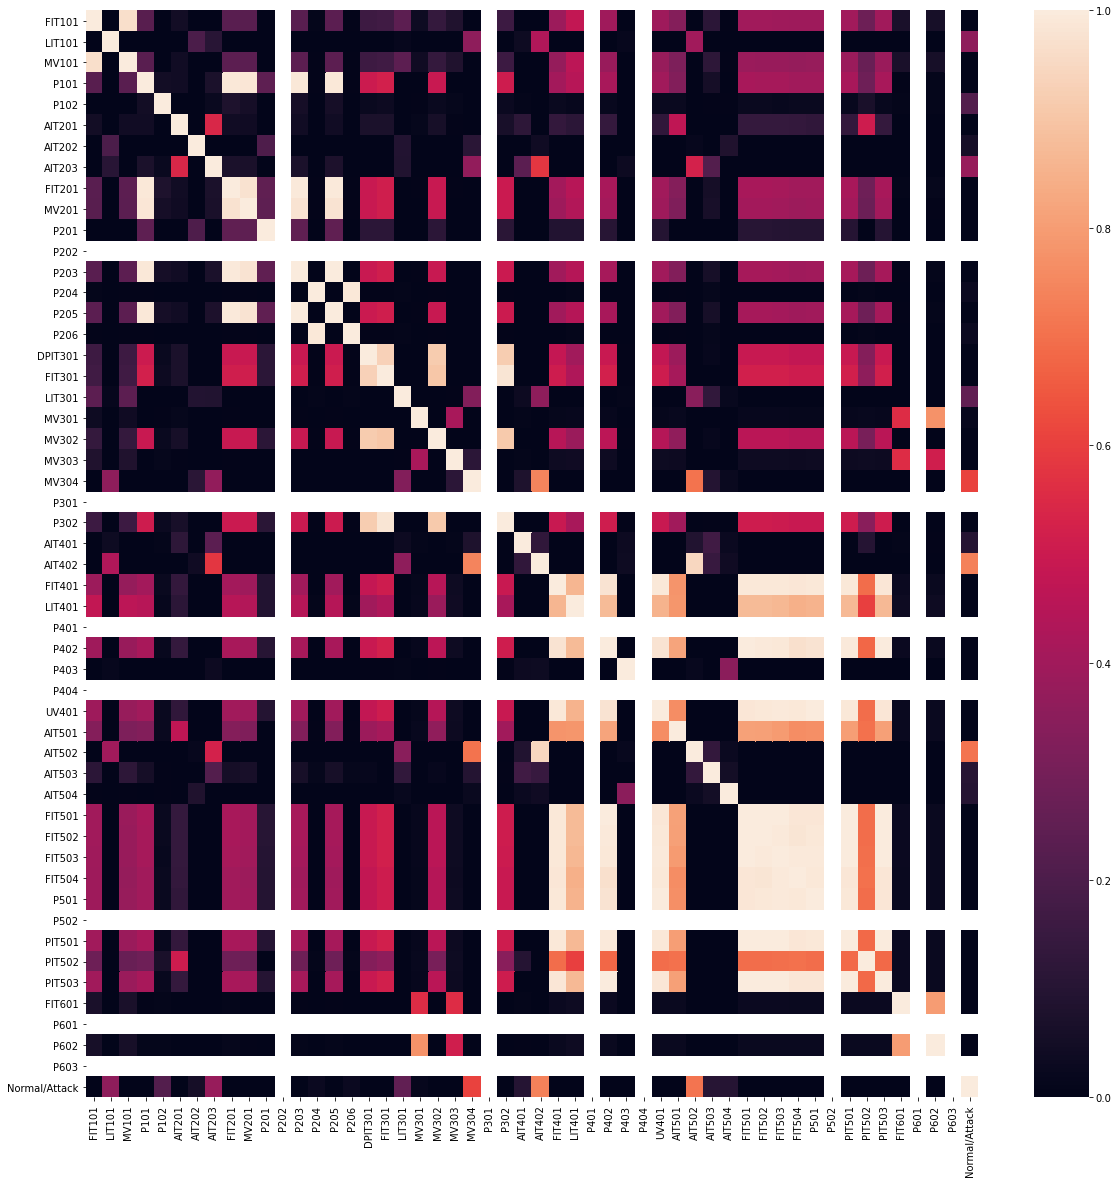

In [453]:
plt.figure(figsize = (20,20))
sns.heatmap(dataset.corr(), vmin = 0);

Removing features, which aren't changing during time

In [454]:
drop_list = []
for column in dataset:
    if dataset[column].dtype != 'object' and dataset[column].std() == 0:
        drop_list.append(column)
dataset.drop(drop_list, axis = 1, inplace = True)

Removing features with high corr

In [455]:
dataset_clear

,FIT101,LIT101,P102,AIT201,AIT202,AIT203,FIT201,P201,P204,DPIT301,...,MV304,AIT401,AIT402,FIT401,AIT501,AIT503,AIT504,PIT502,FIT601,Normal/Attack
0,0.600586,-0.674336,-0.084239,1.458226,-1.136737,0.486911,0.659291,-0.369207,-0.011238,0.508849,...,-0.314062,0.540992,-0.136773,0.276581,1.070174,-0.040725,-0.306735,1.529002,-0.102959,0
1,0.616692,-0.674023,-0.084239,1.458226,-1.136737,0.486911,0.659291,-0.369207,-0.011238,0.508849,...,-0.314062,0.540992,-0.136773,0.281967,1.070174,-0.040725,-0.306735,1.529002,-0.102959,0
2,0.652661,-0.674336,-0.084239,1.458226,-1.153491,0.486911,0.656574,-0.369207,-0.011238,0.501419,...,-0.314062,0.540992,-0.136773,0.281967,1.070174,-0.040725,-0.306735,1.529002,-0.102959,0
3,0.690509,-0.673398,-0.084239,1.458226,-1.153491,0.486911,0.656574,-0.369207,-0.011238,0.501419,...,-0.314062,0.540992,-0.136773,0.279131,1.070174,-0.040725,-0.306735,1.529002,-0.102959,0
4,0.719767,-0.669335,-0.084239,1.458226,-1.153491,0.486911,0.657253,-0.369207,-0.011238,0.501419,...,-0.314062,0.540992,-0.136773,0.279131,1.070174,-0.040725,-0.306735,1.529002,-0.102959,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443496,0.718156,-0.845287,-0.084239,-1.172182,0.714243,-0.781766,0.668010,-0.369207,-0.011238,-1.724084,...,2.760363,-0.695144,-0.397036,0.270911,-0.410952,-0.397367,0.111387,-0.205743,-0.103762,0
443497,0.754663,-0.849350,-0.084239,-1.172182,0.714243,-0.781766,0.668010,-0.369207,-0.011238,-1.727800,...,2.760363,-0.695144,-0.397036,0.270911,-0.410952,-0.397367,0.111387,-0.205743,-0.103762,0
443498,0.773452,-0.850913,-0.084239,-1.172182,0.714243,-0.784855,0.668010,-0.369207,-0.011238,-1.727800,...,2.760363,-0.695144,-0.397036,0.270911,-0.384503,-0.397367,0.111387,-0.205743,-0.103762,0
443499,0.796805,-0.848725,-0.084239,-1.172182,0.714243,-0.791026,0.668010,-0.369207,-0.011238,-1.723672,...,2.760363,-0.695144,-0.397036,0.270911,-0.384503,-0.397367,0.111387,-0.205743,-0.103762,0


In [456]:
drop_list2 = ['MV101',"P101",'P203','MV201','P205', 'MV302', 'FIT301',
                              'P302', 'P206', 'P403', 'FIT501', 'FIT502', 'FIT503', 'FIT504',
                             'P501', 'LIT401', 'P402','UV401', 'AIT502', 'PIT501', 'PIT503', 'P602','Timestamp']
dataset_clear = dataset.drop(drop_list2, axis = 1)
drop_list_full = drop_list2 + drop_list

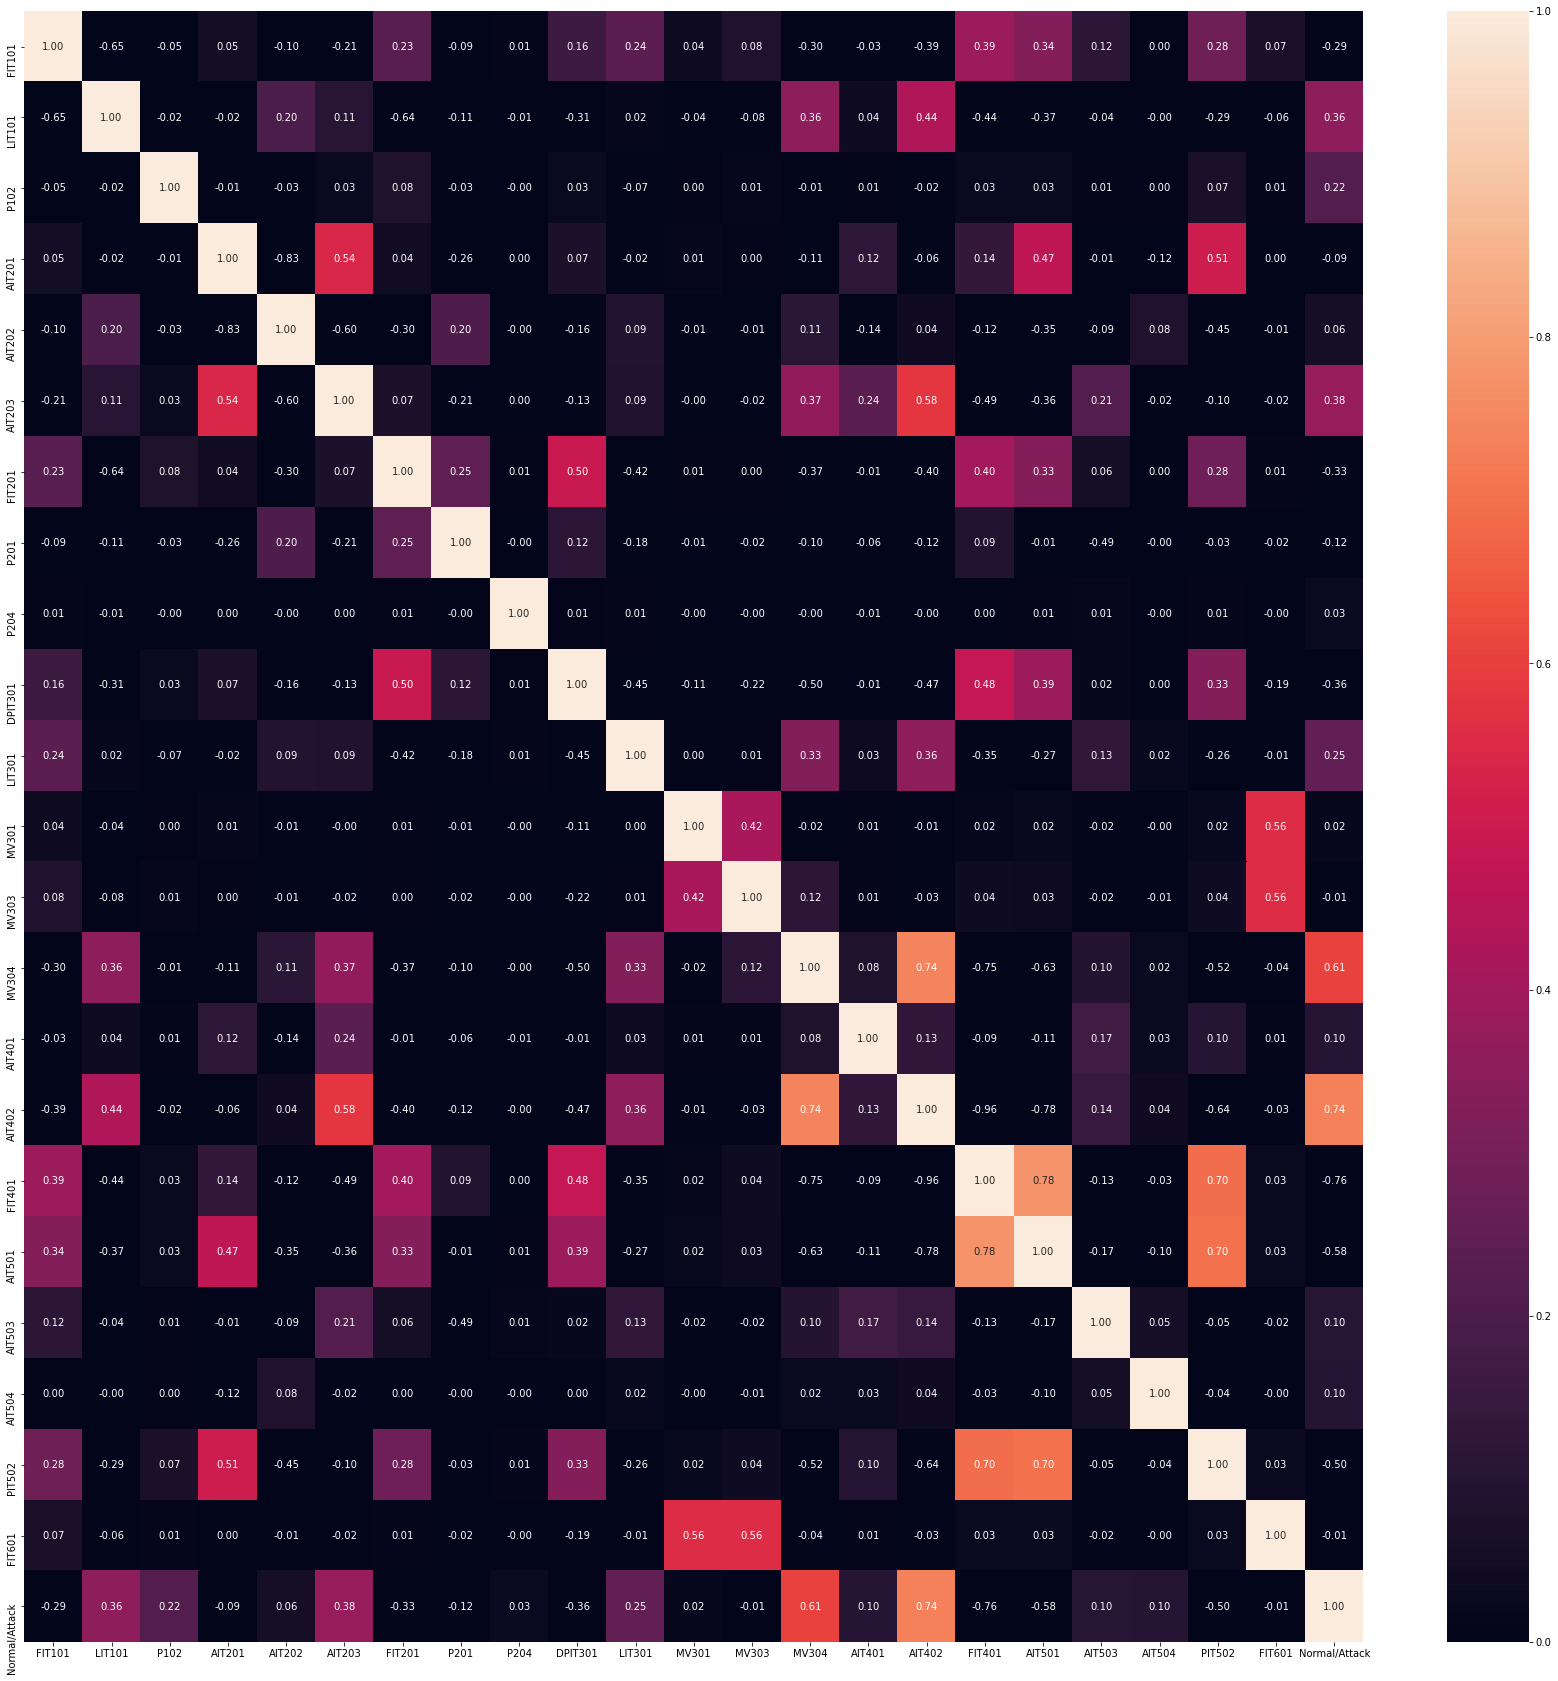

In [457]:
plt.figure(figsize = (30,30))
sns.heatmap(dataset_clear.corr(), vmin = 0, annot=True, fmt = '.2f');

Scaling features

In [458]:
scaler = StandardScaler()

scaler.fit(dataset_clear.iloc[:,:-1].values)
scaled_data = scaler.transform(dataset_clear.iloc[:,:-1].values)

dataset_clear.iloc[:,:-1] = scaled_data

Dropping the same rows

In [459]:
dataset_clear_nodupl = dataset_clear.drop_duplicates(ignore_index = True)
dataset_clear_nodupl

,FIT101,LIT101,P102,AIT201,AIT202,AIT203,FIT201,P201,P204,DPIT301,...,MV304,AIT401,AIT402,FIT401,AIT501,AIT503,AIT504,PIT502,FIT601,Normal/Attack
0,0.598055,-0.671759,-0.083632,1.471045,-1.150243,0.501005,0.656905,-0.37114,-0.011157,0.506541,...,-0.312151,0.551475,-0.131916,0.274596,1.082496,-0.037017,-0.310733,1.542306,-0.102994,0
1,0.614180,-0.671445,-0.083632,1.471045,-1.150243,0.501005,0.656905,-0.37114,-0.011157,0.506541,...,-0.312151,0.551475,-0.131916,0.280018,1.082496,-0.037017,-0.310733,1.542306,-0.102994,0
2,0.650193,-0.671759,-0.083632,1.471045,-1.166987,0.501005,0.654184,-0.37114,-0.011157,0.499097,...,-0.312151,0.551475,-0.131916,0.280018,1.082496,-0.037017,-0.310733,1.542306,-0.102994,0
3,0.688087,-0.670818,-0.083632,1.471045,-1.166987,0.501005,0.654184,-0.37114,-0.011157,0.499097,...,-0.312151,0.551475,-0.131916,0.277163,1.082496,-0.037017,-0.310733,1.542306,-0.102994,0
4,0.717381,-0.666746,-0.083632,1.471045,-1.166987,0.501005,0.654865,-0.37114,-0.011157,0.499097,...,-0.312151,0.551475,-0.131916,0.277163,1.082496,-0.037017,-0.310733,1.542306,-0.102994,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441442,0.709587,-0.698072,-0.083632,-1.200283,0.959112,-1.105097,0.669377,2.69440,-0.011157,0.590498,...,-0.312151,-0.682855,-0.366258,0.256330,-0.494808,-1.173337,0.037745,-0.359524,-0.103797,0
441443,0.700449,-0.691180,-0.083632,-1.200283,0.959112,-1.105097,0.669377,2.69440,-0.011157,0.590498,...,-0.312151,-0.682855,-0.366258,0.256330,-0.494808,-1.173337,0.037745,-0.359524,-0.103797,0
441444,0.685668,-0.688988,-0.083632,-1.200283,0.959112,-1.105097,0.669944,2.69440,-0.011157,0.581814,...,-0.312151,-0.682855,-0.367404,0.258327,-0.494808,-1.173337,0.037745,-0.359524,-0.103797,0
441445,0.677068,-0.688674,-0.083632,-1.200283,0.959112,-1.105097,0.669944,2.69440,-0.011157,0.577264,...,-0.312151,-0.682855,-0.367404,0.258327,-0.494808,-1.173337,0.037745,-0.359524,-0.103797,0


In [460]:
X = dataset_clear_nodupl.drop('Normal/Attack', axis = 1)
Y = dataset_clear_nodupl['Normal/Attack']

In [461]:
X_train, X_test, y_train,  y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

In [462]:
X_train

,FIT101,LIT101,P102,AIT201,AIT202,AIT203,FIT201,P201,P204,DPIT301,...,MV303,MV304,AIT401,AIT402,FIT401,AIT501,AIT503,AIT504,PIT502,FIT601
146496,0.709587,-0.855643,-0.083632,0.697263,-0.740085,0.761494,0.661894,-0.37114,-0.011157,0.542936,...,-0.128684,-0.312151,0.551475,-0.194942,0.267175,0.333752,0.060949,-0.151014,-0.475963,-0.103797
384146,0.674380,0.878267,-0.083632,-0.874911,1.399946,-1.712396,-1.506630,-0.37114,-0.011157,0.575610,...,-0.128684,-0.312151,0.551475,-0.413240,0.278306,-0.019715,0.212796,0.100664,-0.475963,-0.103797
350883,0.745869,-0.655468,-0.083632,-0.938709,0.995379,-1.340927,0.666996,2.69440,-0.011157,0.561135,...,-0.128684,-0.312151,-0.682855,-0.377717,0.298854,0.238743,-1.814982,0.013545,-0.204273,-0.103797
231463,-1.438554,1.647955,-0.083632,-0.617896,0.721946,0.525664,-1.506630,-0.37114,-0.011157,-1.786776,...,-0.128684,2.773488,-0.682855,3.161474,-3.541405,-1.646422,0.305855,0.081304,-2.455421,-0.103797
355155,0.708243,-2.435116,-0.083632,-0.936886,0.498738,-0.915511,0.662120,-0.37114,-0.011157,0.552449,...,-0.128684,-0.312151,-0.682855,-0.396624,0.293432,0.060099,0.281353,0.178103,-0.087834,-0.103797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286114,0.741569,-0.837475,-0.083632,-0.904076,0.350859,-0.208026,0.654865,-0.37114,-0.011157,0.562375,...,-0.128684,-0.312151,-0.682855,-0.290053,0.263180,-0.031114,0.095234,0.066785,-0.281898,-0.103797
313468,0.592411,-0.822751,-0.083632,-0.976988,0.512688,-0.439226,0.662120,-0.37114,-0.011157,-0.801622,...,-0.128684,2.773488,0.551475,-0.322141,0.269173,-0.209745,0.893604,0.032904,-0.553589,-0.103797
212835,0.758231,-0.639492,-0.083632,-0.468424,-0.003501,0.311420,0.659626,-0.37114,-0.011157,0.516880,...,-0.128684,-0.312151,-0.682855,-0.260259,0.280588,-0.335179,1.339333,0.158744,-0.320711,-0.103797
9738,-1.438554,1.632918,-0.083632,1.511150,-0.776361,-0.241932,-1.506630,-0.37114,-0.011157,-1.785122,...,-0.128684,-0.312151,0.551475,-0.186348,0.297712,0.953268,-0.007623,-0.238134,1.852810,-0.102994


Trying to balance classes

In [463]:
cutted_index = y_train[y_train==0][200000::].index
attack_index = y_train[y_train==1].index

y_train_cutted = y_train[cutted_index]
X_train_cutted = X_train.loc[cutted_index]

y_train = np.hstack((y_train_cutted,y_train[attack_index] ))

X_train = pd.concat([X_train_cutted, X_train.loc[attack_index]])

Training model

In [464]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
pred = xgb.predict(X_test)
accuracy_score(y_test,pred)

C:\Users\79175\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\79175\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:58:40] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9995129686261185

We got overfitting, so let's try to split data by time

In [465]:
n_samples = dataset_clear_nodupl.shape[0]
tscv = TimeSeriesSplit(n_splits = 4, test_size = round(n_samples*0.2) )

In [466]:
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    xgb = XGBClassifier()
    xgb.fit(X_train,y_train)
    prediction = xgb.predict(X_test)
    print(accuracy_score(y_test,prediction))
    print(f1_score(y_test,prediction))

TRAIN: [    0     1     2 ... 88288 88289 88290] TEST: [ 88291  88292  88293 ... 176577 176578 176579]
[23:58:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\79175\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9497672416722355
0.2255980443513183
TRAIN: [     0      1      2 ... 176577 176578 176579] TEST: [176580 176581 176582 ... 264866 264867 264868]


C:\Users\79175\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:58:51] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9383615172898097
0.9228019405906884
TRAIN: [     0      1      2 ... 264866 264867 264868] TEST: [264869 264870 264871 ... 353155 353156 353157]


C:\Users\79175\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:58:57] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.18163078073146144
0.05337560758316193
TRAIN: [     0      1      2 ... 353155 353156 353157] TEST: [353158 353159 353160 ... 441444 441445 441446]


C:\Users\79175\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:59:07] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9475699124466241
0.0


In [473]:
X_train , y_train = X[0:176580], Y[0:176580]
X_test , y_test = X[176580:264869], Y[176580:264869]

xgb = XGBClassifier()
xgb.fit(X_train,y_train)
pred = xgb.predict(X_test)
print('Model accuracy - ',accuracy_score(y_test,pred))
print('Model f1_score - ',f1_score(y_test,pred))
print('Model recall - ',recall_score(y_test,pred))
print('Model precision - ',precision_score(y_test,pred))

C:\Users\79175\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\79175\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:29:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model accuracy -  0.9383615172898097
Model f1_score -  0.9228019405906884
Model recall -  0.8938169826875515
Model precision -  0.9537297677691766
